# **Database Monitoring Script - Cocaine Seizures 2025 (Google Sheets)**
#### InSight Crime - MAD Unit 
June, 2025

---------------------



## Setup

#### Version Control

The project is created within a single GitHub repository ([FelipeVillota/db-check-cocaine-seizures](https://github.com/FelipeVillota/db-check-cocaine-seizures)). I keep the repository `private` with the possibility to give access to the online repo at any time. 

#### Reproducible Environment

In [58]:
# IMPORTANT
# To create venv
# python -m venv venv-db-watch

# To activate environment, run in Terminal:
# # (optional, temporary auth) 
# Set-ExecutionPolicy -Scope Process -ExecutionPolicy Bypass 
# venv-db-watch\Scripts\activate

# Then select respective kernel --> also install ipykernel package to connect to kernel

# Update list master list
# pip freeze > requirements.txt

In [2]:
# Checking venv-db-watch works
import sys
print(sys.executable)

c:\Users\USER\Desktop\ic\db-check-cocaine-seizures\venv-db-watch\Scripts\python.exe


#### Loading Libraries

In [60]:
# pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib pandas

In [3]:
import os
import re
import requests
import pandas as pd
from datetime import datetime
from google.oauth2 import service_account
from googleapiclient.discovery import build
import gspread
from google.oauth2.service_account import Credentials
from gspread_formatting import format_cell_ranges, CellFormat, Color
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# pip freeze > requirements.txt

### Accessing the API

This creates a modular client (frontend) call that is able to extract the desired subset of data from the API server (backend); -and, make it easily reusable for future queries.


In [4]:
# Configure Google Drive API

# Path to your service account key file
SERVICE_ACCOUNT_FILE = 'C:/Users/USER/Desktop/ic/llavero/summer-sector-439022-v6-2eafffbbfb90.json' # Update with the actual path or team credentials file

# VERY IMPORTANT: Ensure the service account has access to the Google Sheet by sharing it with the service account email

# Original (latest version) Google Sheet ID
ORIGINAL_SPREADSHEET_ID =  '1t61MafCmnRe2QN082Bk1V0IxBSIW8UUqH1g5mULgb2o' # HANDLE WITH CAUTION

# Test Google Sheet ID
TEST_SPREADSHEET_ID = '1IiJiYJQShM_FrBQAgraNlpTg5DfKuJDCbJhhi4LRHg0'

# '1tERxVx_Ay4WDOXIvEXezFpiBZKBPUJNuZQl8NUpHt1g' 

# Define the sheet tab or range to read
RANGE_NAME = '2025'

# Define scopes for Google Sheets and Drive API
SCOPES = ['https://www.googleapis.com/auth/spreadsheets', 
          'https://www.googleapis.com/auth/drive']

In [5]:
# Authenticate and build both Sheets and Drive services
creds = service_account.Credentials.from_service_account_file(
    SERVICE_ACCOUNT_FILE, scopes=SCOPES)
sheet_service = build('sheets', 'v4', credentials=creds)
drive_service = build('drive', 'v3', credentials=creds)

In [6]:
# Verify last modifying user and time of the original spreadsheet. This information is related to the file itself, not to specific content (sheets, cells, rows)

from googleapiclient.discovery import build
from datetime import datetime
import pytz

def get_last_modifying_user(drive_service, file_id):
    try:
        # Get revisions (only the last one)
        revisions = drive_service.revisions().list(
            fileId=file_id,
            fields="revisions(modifiedTime,lastModifyingUser)"
        ).execute().get('revisions', [])
        
        if not revisions:
            return "No revisions found."
        
        last_revision = revisions[-1]  # Most recent revision
        user_info = last_revision.get('lastModifyingUser', {})
        email = user_info.get('emailAddress', 'Unknown')
        modified_time = last_revision.get('modifiedTime', 'Unknown')
        
        # Convert to readable datetime
        if modified_time != 'Unknown':
            dt = datetime.strptime(modified_time, "%Y-%m-%dT%H:%M:%S.%fZ")
            dt = dt.replace(tzinfo=pytz.UTC)
            modified_time = dt.strftime("%Y-%m-%d %H:%M:%S (UTC)")
        
        return {
            "user_email": email,
            "modified_time": modified_time
        }
    
    except Exception as e:
        return f"Error: {str(e)}"

# Usage
# First get the file name and sheet name
file_metadata = drive_service.files().get(fileId=ORIGINAL_SPREADSHEET_ID, fields='name').execute()
file_name = file_metadata.get('name', 'Unknown')

# Get sheet names
sheets = sheet_service.spreadsheets().get(
    spreadsheetId=ORIGINAL_SPREADSHEET_ID,
    fields='sheets(properties(title))'
).execute().get('sheets', [])

sheet_names = [sheet['properties']['title'] for sheet in sheets]

# Get last modifier info
last_modifier = get_last_modifying_user(drive_service, ORIGINAL_SPREADSHEET_ID)

# Print all information
print(f"📄 File name: {file_name}")
print(f"📑 Sheet names: {', '.join(sheet_names)}")
print(f"🔄 Last modified by: {last_modifier['user_email']}")
print(f"⏰ Last modified at: {last_modifier['modified_time']}")

📄 File name: incautaciones cocaina 01-02
📑 Sheet names: Seizures, Guide, 2025, 2024, VRAEM, 2023, Primary Sources, origins
🔄 Last modified by: mpeters@insightcrime.org
⏰ Last modified at: 2025-07-21 20:43:13 (UTC)


### Loading Data

In [8]:
# Load data
 
# Call the Sheets API to read data
sheet = sheet_service.spreadsheets()
result = sheet.values().get(spreadsheetId=TEST_SPREADSHEET_ID, range=RANGE_NAME).execute()
values = result.get('values', [])

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(values[1:], columns=values[0])
print(df.head()) 

      Type   Time unit        Date Date 2  Year Month Day Duration  \
0  Seizure  Individual  2025-03-24         2025     3  24            
1  Seizure  Individual  2025-03-23         2025     3  23            
2  Seizure  Individual  2025-03-22         2025     3  22            
3  Seizure  Individual  2025-03-22         2025     3  22            
4  Seizure  Individual  2025-03-19         2025     3  19            

                       Type Drugs Quantity  ... Destition - department.state  \
0                         Cocaine       10  ...                                
1                         Cocaine      2.5  ...                                
2                         Cocaine     2619  ...                                
3  Other (explain in Description)     1240  ...                                
4                         Cocaine    16.05  ...                                

  Destition - Municipality/Port Destition 2 - Country  \
0                                        

### Pre-processing

In [9]:
# Handle Missing/Invalid Values. We want to keep this step as simple as possible, as we will be changing the data structure later.
 
df = df.replace('', pd.NA)  # Convert empty strings to NA
df = df.replace(r'^\s*$', pd.NA, regex=True)  # Convert whitespace to NA
print("✓ Converted empty strings/whitespace to NA values")

✓ Converted empty strings/whitespace to NA values


In [10]:
# Indentify Existing Dropdowns
 
def get_sheet_dropdowns(spreadsheet_id, sheet_name, creds):
    service = build('sheets', 'v4', credentials=creds)
    sheet_metadata = service.spreadsheets().get(
        spreadsheetId=spreadsheet_id,
        ranges=[sheet_name],
        includeGridData=True
    ).execute()

    dropdowns_by_column = {}

    for sheet in sheet_metadata['sheets']:
        if sheet['properties']['title'] != sheet_name:
            continue

        col_dropdowns = {}
        rows = sheet['data'][0]['rowData']
        header_row = rows[0]['values']
        col_names = [cell.get('formattedValue', f"Column_{i}") for i, cell in enumerate(header_row)]

        for col_idx, col_name in enumerate(col_names):
            dropdowns_in_col = set()
            for row in rows[1:]:  # Skip header
                cell = row['values'][col_idx]
                if 'dataValidation' in cell:
                    dv = cell['dataValidation']
                    if dv['condition']['type'] == 'ONE_OF_LIST':
                        values = [v['userEnteredValue'] for v in dv['condition']['values']]
                        dropdowns_in_col.update(values)
            if dropdowns_in_col:
                col_dropdowns[col_name] = list(dropdowns_in_col)

        dropdowns_by_column.update(col_dropdowns)

    return dropdowns_by_column

dropdown_options = get_sheet_dropdowns(TEST_SPREADSHEET_ID, '2025', creds)

# Print results
for col, options in dropdown_options.items():
    print(f"🔽 {col}: {options}")


🔽 Type: ['Other (explain in Description)', 'Price', 'Crop Eradication', 'Seizure', 'Total Crop Cultivation Estimate', 'Total Production Estimate']
🔽 Time unit: ['Month', 'Multi-Year', 'Other (explain in Description)', 'Individual', 'Multi-Month', 'Year']
🔽 Type Drugs: ['Cocaine', 'Other (explain in Description)', 'Coca Crops', 'Cocaine - Crack', 'Cocaine Base', 'All/Unspecified/Multiple']
🔽 Weight unit: ['Percent', 'Pounds (lbs)', 'USD', 'Other currency (say which in Description)', 'Other (explain in Description)', 'Package', 'Hectare', 'Plant', 'Pounds (£)', 'Kilogram', 'Euro']
🔽 Modus Operandi/place of seizure: ['Container', 'Air', 'Land', 'Maritime vessel', 'River vessel']
🔽 Region: ['Caribbean', 'Oceania', 'Central America', 'Europe', 'Africa', 'South America', 'North America', 'Global', 'Asia']
🔽 Origin country: ['Bolivia', '""', 'Colombia', 'Peru']
🔽 Transit 1/Region: ['Caribbean', 'Oceania', 'Central America', 'Europe', 'Africa', 'South America', 'North America', 'Global', 'Asia

## Monitoring

##### Summary Stats

In [11]:
def get_dataframe_summary(df):
    # --- General DataFrame Info ---
    general_info = {
        "Shape": f"{df.shape[0]} rows × {df.shape[1]} cols",
        "Memory Usage": f"{df.memory_usage(deep=True).sum() / (1024 ** 2):.2f} MB",
        "Columns with NA": f"{df.isna().any().sum()} / {len(df.columns)}",
        "Duplicate Rows": f"{df.duplicated().sum()} ({(df.duplicated().mean() * 100):.1f}%)",
        "Numeric Columns": f"{df.select_dtypes(include='number').shape[1]}",
        "Categorical Columns": f"{df.select_dtypes(include=['object', 'category']).shape[1]}",
        "Datetime Columns": f"{df.select_dtypes(include='datetime').shape[1]}"
    }

  # --- Compute dropdown options per column ---
    dropdown_options_dict = {
        col: dropdown_options.get(col, [])
        for col in df.columns
    }
    # --- Column-Level Stats ---
    column_stats = pd.DataFrame({
        'Variable': df.columns,
        'Dtype': df.dtypes.values,
        'Unique_Count': df.nunique().values,
        'NA_Count': df.isna().sum().values,
        'NA_Percentage': (df.isna().mean() * 100).round(1).values,
        'Duplicate_Count': df.apply(lambda col: col.duplicated(keep=False).sum()).values,
        'Duplicate_Percentage': (df.apply(lambda col: col.duplicated(keep=False).mean()) * 100).round(1).values,
        'Unique_Values': df.apply(lambda x: x.drop_duplicates().tolist()).values,
        'Dropdown_Options': [dropdown_options_dict[col] for col in df.columns],
        'Dropdown_Option_Count': [len(dropdown_options_dict[col]) for col in df.columns]
    }).sort_values('Unique_Count', ascending=False)


    # Format percentages
    column_stats['NA_Percentage'] = column_stats['NA_Percentage'].astype(str) + '%'
    column_stats['Duplicate_Percentage'] = column_stats['Duplicate_Percentage'].astype(str) + '%'

    return general_info, column_stats

# Run the summary
general_info, column_stats = get_dataframe_summary(df)

# Print General Info
print("=== GENERAL DATAFRAME INFO ===")
for key, value in general_info.items():
    print(f"{key}: {value}")

# Display Column Stats (including dropdown options)
print("\n=== COLUMN-LEVEL STATISTICS ===")
display(column_stats)


=== GENERAL DATAFRAME INFO ===
Shape: 540 rows × 41 cols
Memory Usage: 1.37 MB
Columns with NA: 36 / 41
Duplicate Rows: 0 (0.0%)
Numeric Columns: 0
Categorical Columns: 41
Datetime Columns: 0

=== COLUMN-LEVEL STATISTICS ===


,Variable,Dtype,Unique_Count,NA_Count,NA_Percentage,Duplicate_Count,Duplicate_Percentage,Unique_Values,Dropdown_Options,Dropdown_Option_Count
35,Description,object,535,2,0.4%,8,1.5%,"[Spanish citizen, coming from Lisbon , was sto...",[],0
39,Source link,object,519,0,0.0%,39,7.2%,[https://www.lanazione.it/firenze/cronaca/coca...,[],0
9,Quantity,object,346,3,0.6%,282,52.2%,"[10, 2.5, 2619, 1240, 16.05, 65, 6600, 142, 55...",[],0
17,Municipality/Port,object,325,143,26.5%,261,48.3%,"[Florence, Santo Domingo, Lake Maracaibo , Eag...",[],0
11,seizure_kgs,object,285,125,23.1%,325,60.2%,"[9, 2.5, 2619, 1240, 16.05, 65, 6600, 142, 250...",[],0
16,Department/State,object,253,51,9.4%,373,69.1%,"[<NA>, Zulia, Texas, Cáceres, Azores, Québec, ...",[],0
2,Date,object,125,2,0.4%,516,95.6%,"[2025-03-24, 2025-03-23, 2025-03-22, 2025-03-1...",[],0
24,Transit 1/Municipality,object,88,432,80.0%,468,86.7%,"[<NA>, Matapalo, Rio de Janeiro, Acapulco, Kin...",[],0
23,Transit 1/Department,object,71,418,77.4%,486,90.0%,"[Lisbon, <NA>, Santo Domingo, Paris, Puntarena...",[],0
15,Country,object,55,4,0.7%,523,96.9%,"[Italy, Dominican Republic, Venezuela, United ...",[],0


##### Missing Data


Missing values per column:
Type                                 0
Time unit                            0
Date                                 2
Date 2                             526
Year                                 2
Month                                2
Day                                  3
Duration                           525
Type Drugs                           0
Quantity                             3
Weight unit                          2
seizure_kgs                        125
Modus Operandi/place of seizure      7
Sub MO                             503
Region                               0
Country                              4
Department/State                    51
Municipality/Port                  143
Origin country                     473
Origin Area                        516
Origin municipality                525
Transit 1/Region                   351
Transit 1/country                  338
Transit 1/Department               418
Transit 1/Municipality             43

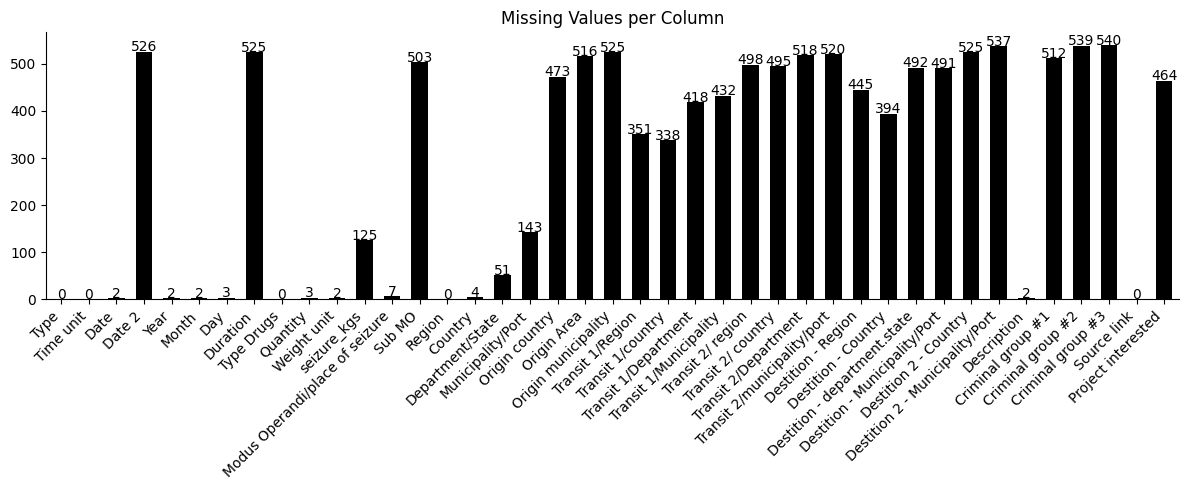

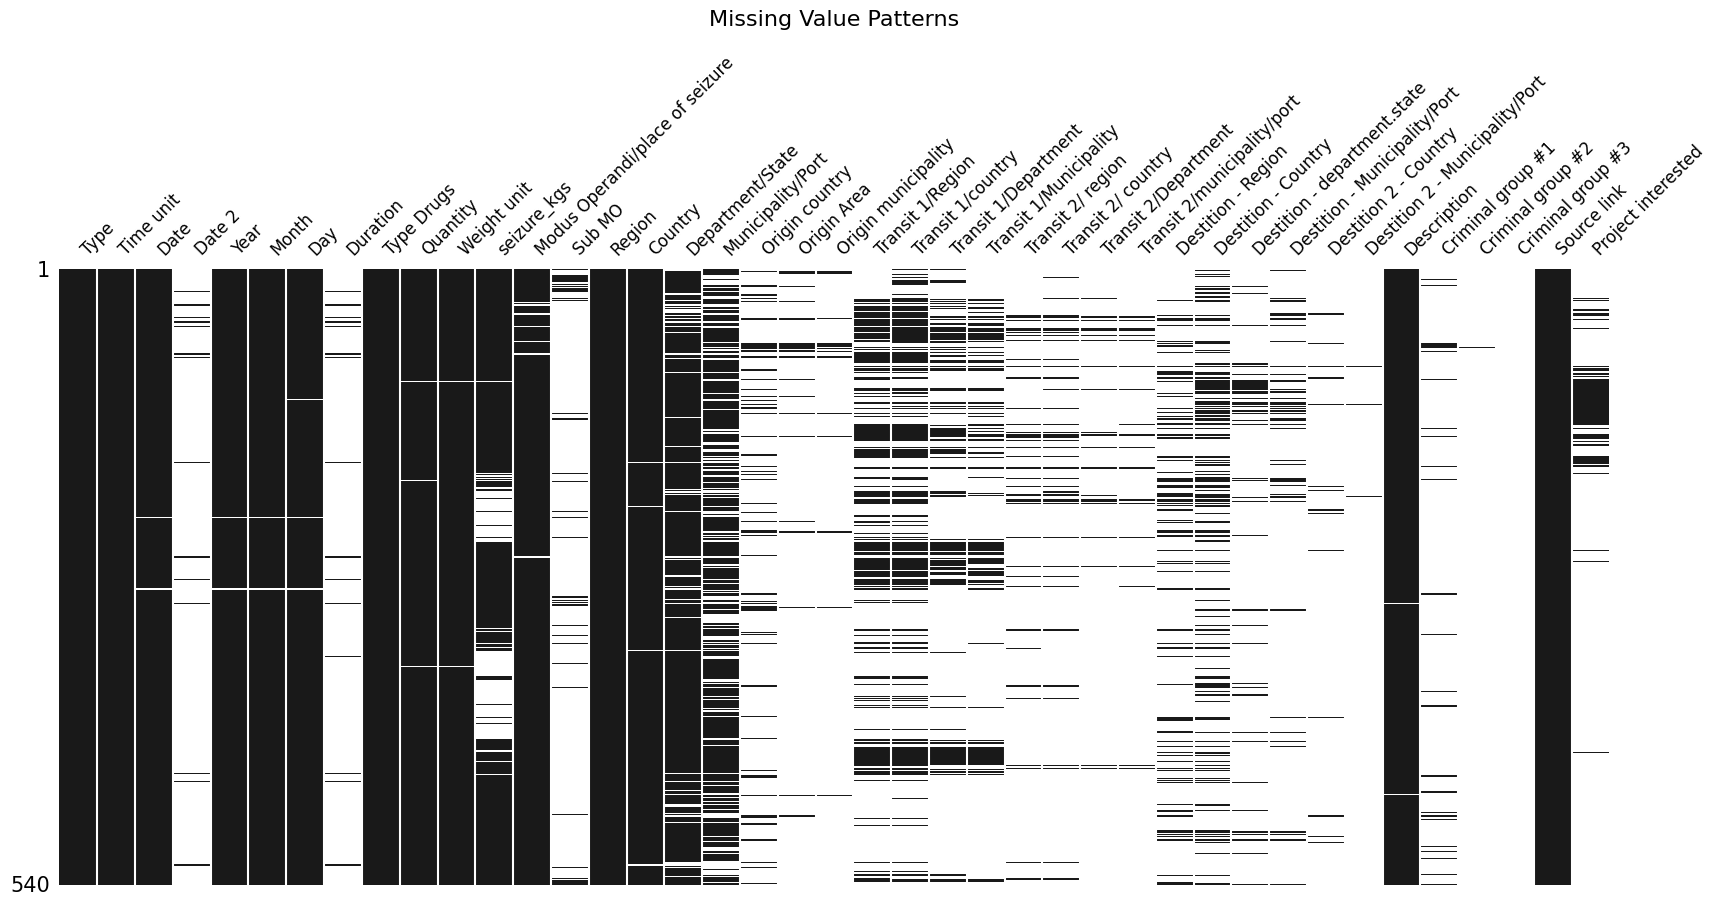

In [12]:

missing_values = df.isnull().sum()
print(f"Missing values per column:\n{missing_values}\n")

# Visualization 1: Bar Chart
plt.figure(figsize=(12, 5))
ax = missing_values.plot(kind='bar', color="#000000", width=0.6)
ax.grid(False)
for i in ax.patches:
    ax.text(i.get_x() + i.get_width()/2, i.get_height()+1, 
            f'{int(i.get_height())}', 
            ha='center', fontsize=10)
plt.xticks(rotation=45, ha='right')
sns.despine()
plt.title("Missing Values per Column")
plt.tight_layout()
plt.show()

# Visualization 2: Missingno Matrix
msno.matrix(
    df,
    figsize=(20, 8),
    color=(0.1, 0.1, 0.1),
    sparkline=False,
    fontsize=12,
    labels=True
)
plt.title("Missing Value Patterns", fontsize=16, pad=20)
plt.show()

##### Key Variables

C:\Users\USER\AppData\Local\Temp\ipykernel_1968\3349938883.py:57: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_text = drug_counts.sort_index(ascending=False).applymap(lambda x: f"{int(x):,}" if pd.notna(x) else "")
C:\Users\USER\AppData\Local\Temp\ipykernel_1968\3349938883.py:57: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_text = drug_counts.sort_index(ascending=False).applymap(lambda x: f"{int(x):,}" if pd.notna(x) else "")
C:\Users\USER\AppData\Local\Temp\ipykernel_1968\3349938883.py:57: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_text = drug_counts.sort_index(ascending=False).applymap(lambda x: f"{int(x):,}" if pd.notna(x) else "")
C:\Users\USER\AppData\Local\Temp\ipykernel_1968\3349938883.py:57: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_text = drug_counts.sort_index(ascending=False).applymap(lambda x

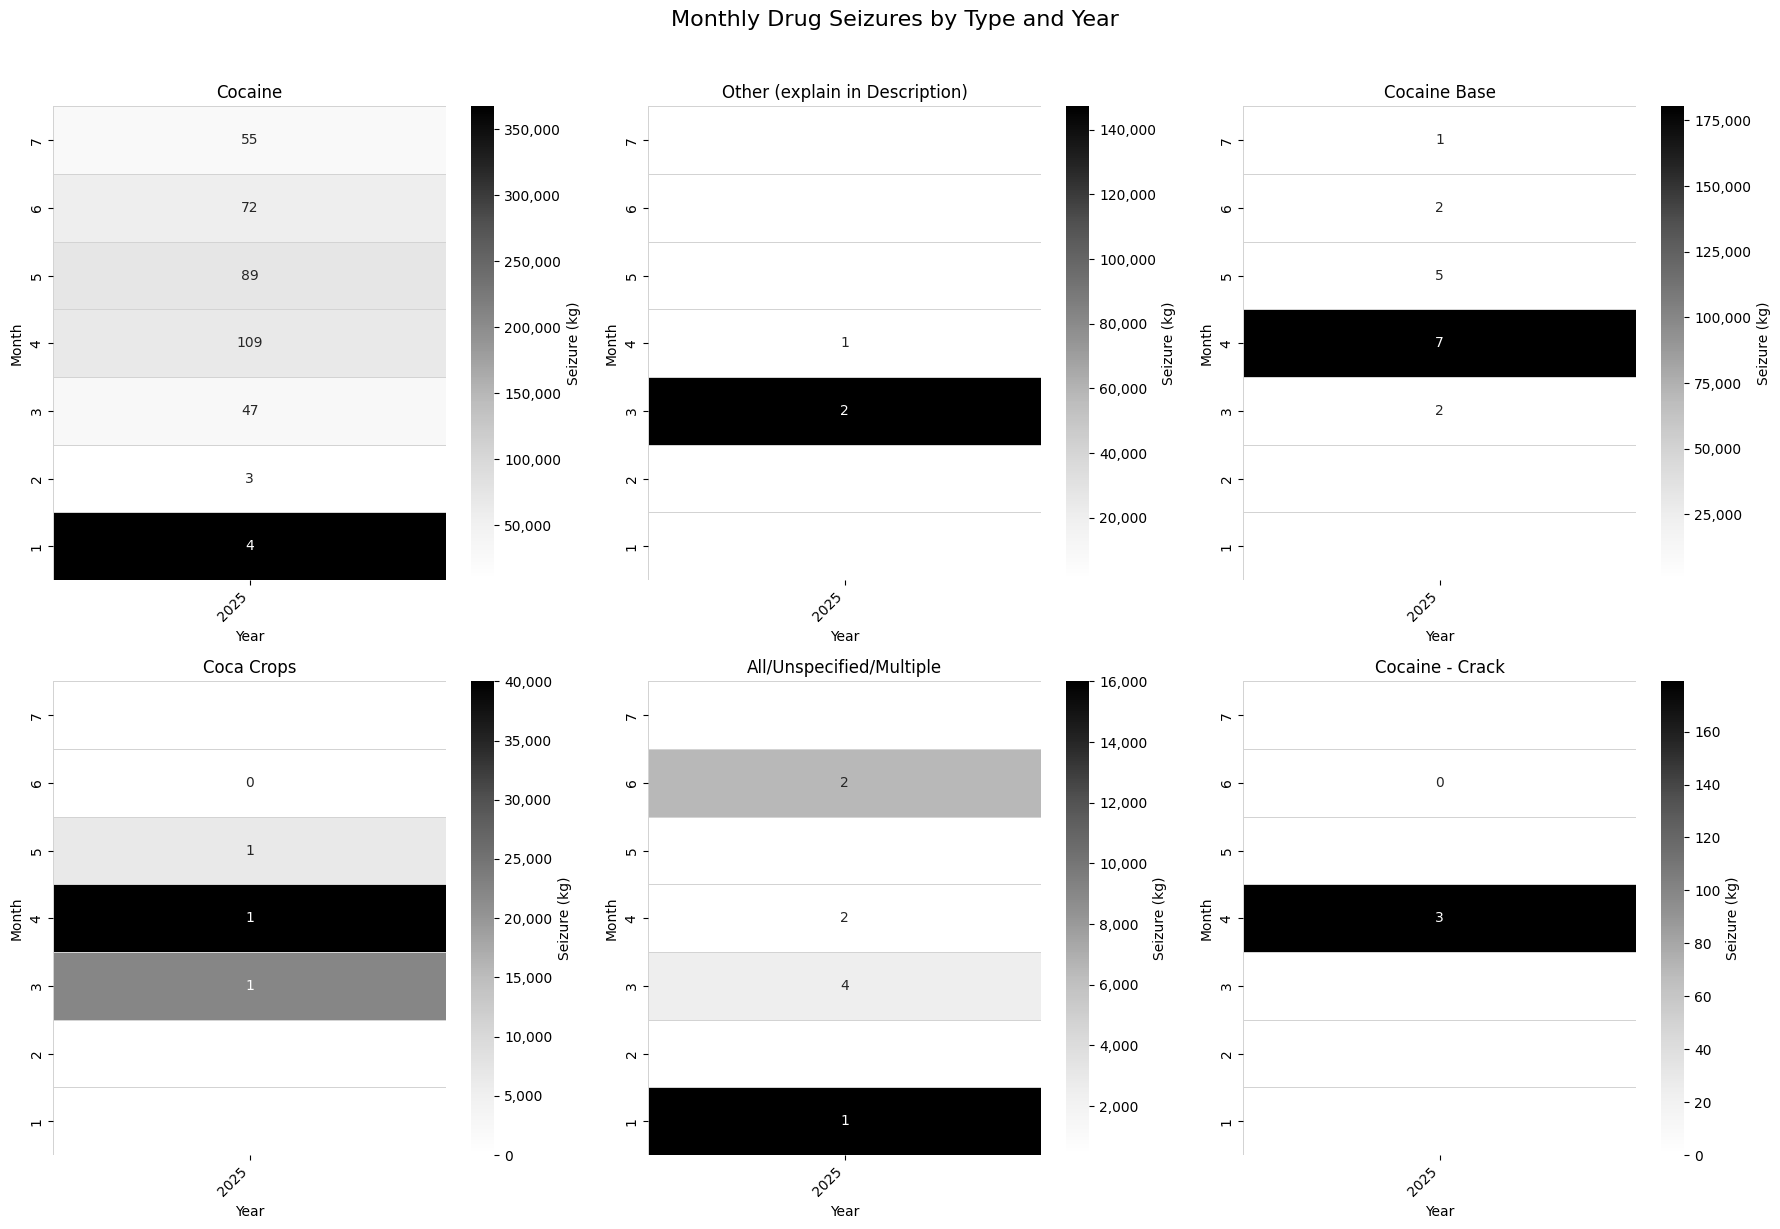

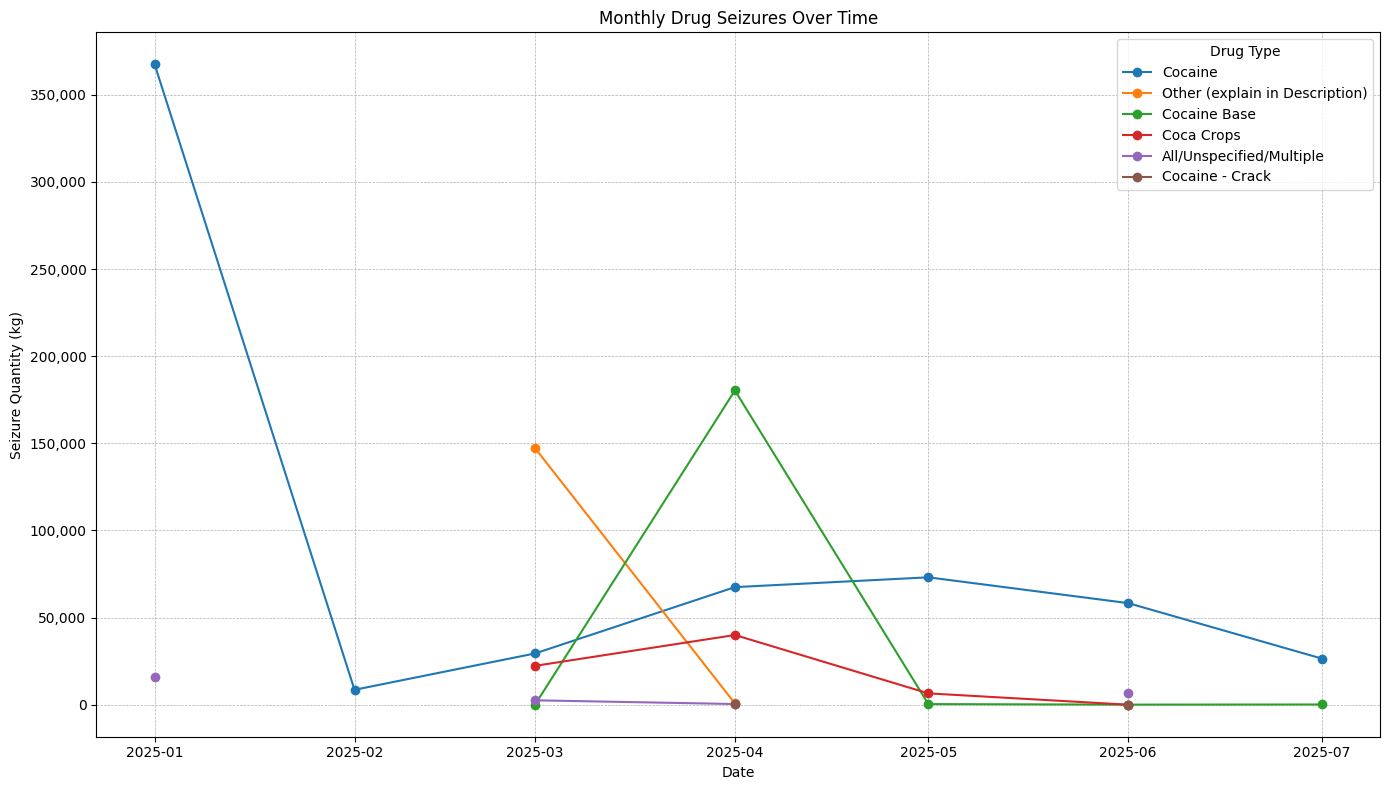

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib.ticker import FuncFormatter

# Convert and clean seizure data
df['seizure_kgs'] = pd.to_numeric(df['seizure_kgs'], errors='coerce')

# Create pivot tables grouped by Type Drugs
pivot_data = df.groupby(['Year', 'Month', 'Type Drugs']).agg(
    seizure_kg=('seizure_kgs', 'sum'),
    event_count=('seizure_kgs', 'count')
).unstack(level=[0, 2])  # Unstack both Year and Type Drugs

# Extract components
seizure_kg = pivot_data['seizure_kg']
event_counts = pivot_data['event_count']

# Fill NaN values with 0
seizure_kg_filled = seizure_kg.fillna(0)

# Get unique drug types for plotting
drug_types = df['Type Drugs'].unique()

# Calculate grid dimensions
n_drugs = len(drug_types)
n_cols = 3  # You can adjust this based on your preference
n_rows = math.ceil(n_drugs / n_cols)

# Create figure for grid layout
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
fig.suptitle("Monthly Drug Seizures by Type and Year", y=1.02, fontsize=16)

# Flatten axes array for easy iteration
if n_rows > 1:
    axes = axes.flatten()
else:
    axes = [axes] if n_cols == 1 else axes

# Function to format numbers with commas
def format_with_commas(x, pos):
    return f"{x:,.0f}"

# Create formatter
comma_formatter = FuncFormatter(format_with_commas)

# Plot heatmap for each drug type in the grid
for i, drug in enumerate(drug_types):
    ax = axes[i]
    
    # Filter data for current drug type
    drug_kg = seizure_kg.xs(drug, level=1, axis=1)
    drug_counts = event_counts.xs(drug, level=1, axis=1)
    
    # Create annotation text with commas
    annot_text = drug_counts.sort_index(ascending=False).applymap(lambda x: f"{int(x):,}" if pd.notna(x) else "")
    
    heatmap = sns.heatmap(
        drug_kg.sort_index(ascending=False),
        cmap="Greys",
        annot=annot_text,
        fmt='',  # Empty string since we pre-formatted
        cbar_kws={'label': f'Seizure (kg)', 'format': comma_formatter},
        linewidths=0.5,
        linecolor='lightgray',
        ax=ax
    )
    
    # Format colorbar ticks with commas
    if heatmap.collections[0].colorbar is not None:
        heatmap.collections[0].colorbar.ax.yaxis.set_major_formatter(comma_formatter)
    
    ax.set_title(drug)
    ax.set_ylabel("Month")
    ax.set_xlabel("Year")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Hide any empty subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Line graph version with comma formatting
plt.figure(figsize=(14,8))

# Create date column for proper time series plotting
df['date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'] + '-01')

# Group by date and drug type
line_data = df.groupby(['date', 'Type Drugs'])['seizure_kgs'].sum().unstack()

# Plot each drug type
for drug in drug_types:
    if drug in line_data.columns:
        plt.plot(line_data.index, line_data[drug], marker='o', label=drug)

plt.title("Monthly Drug Seizures Over Time")
plt.ylabel("Seizure Quantity (kg)")
plt.xlabel("Date")
plt.legend(title="Drug Type")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Format y-axis with commas
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_with_commas))

plt.tight_layout()
plt.show()

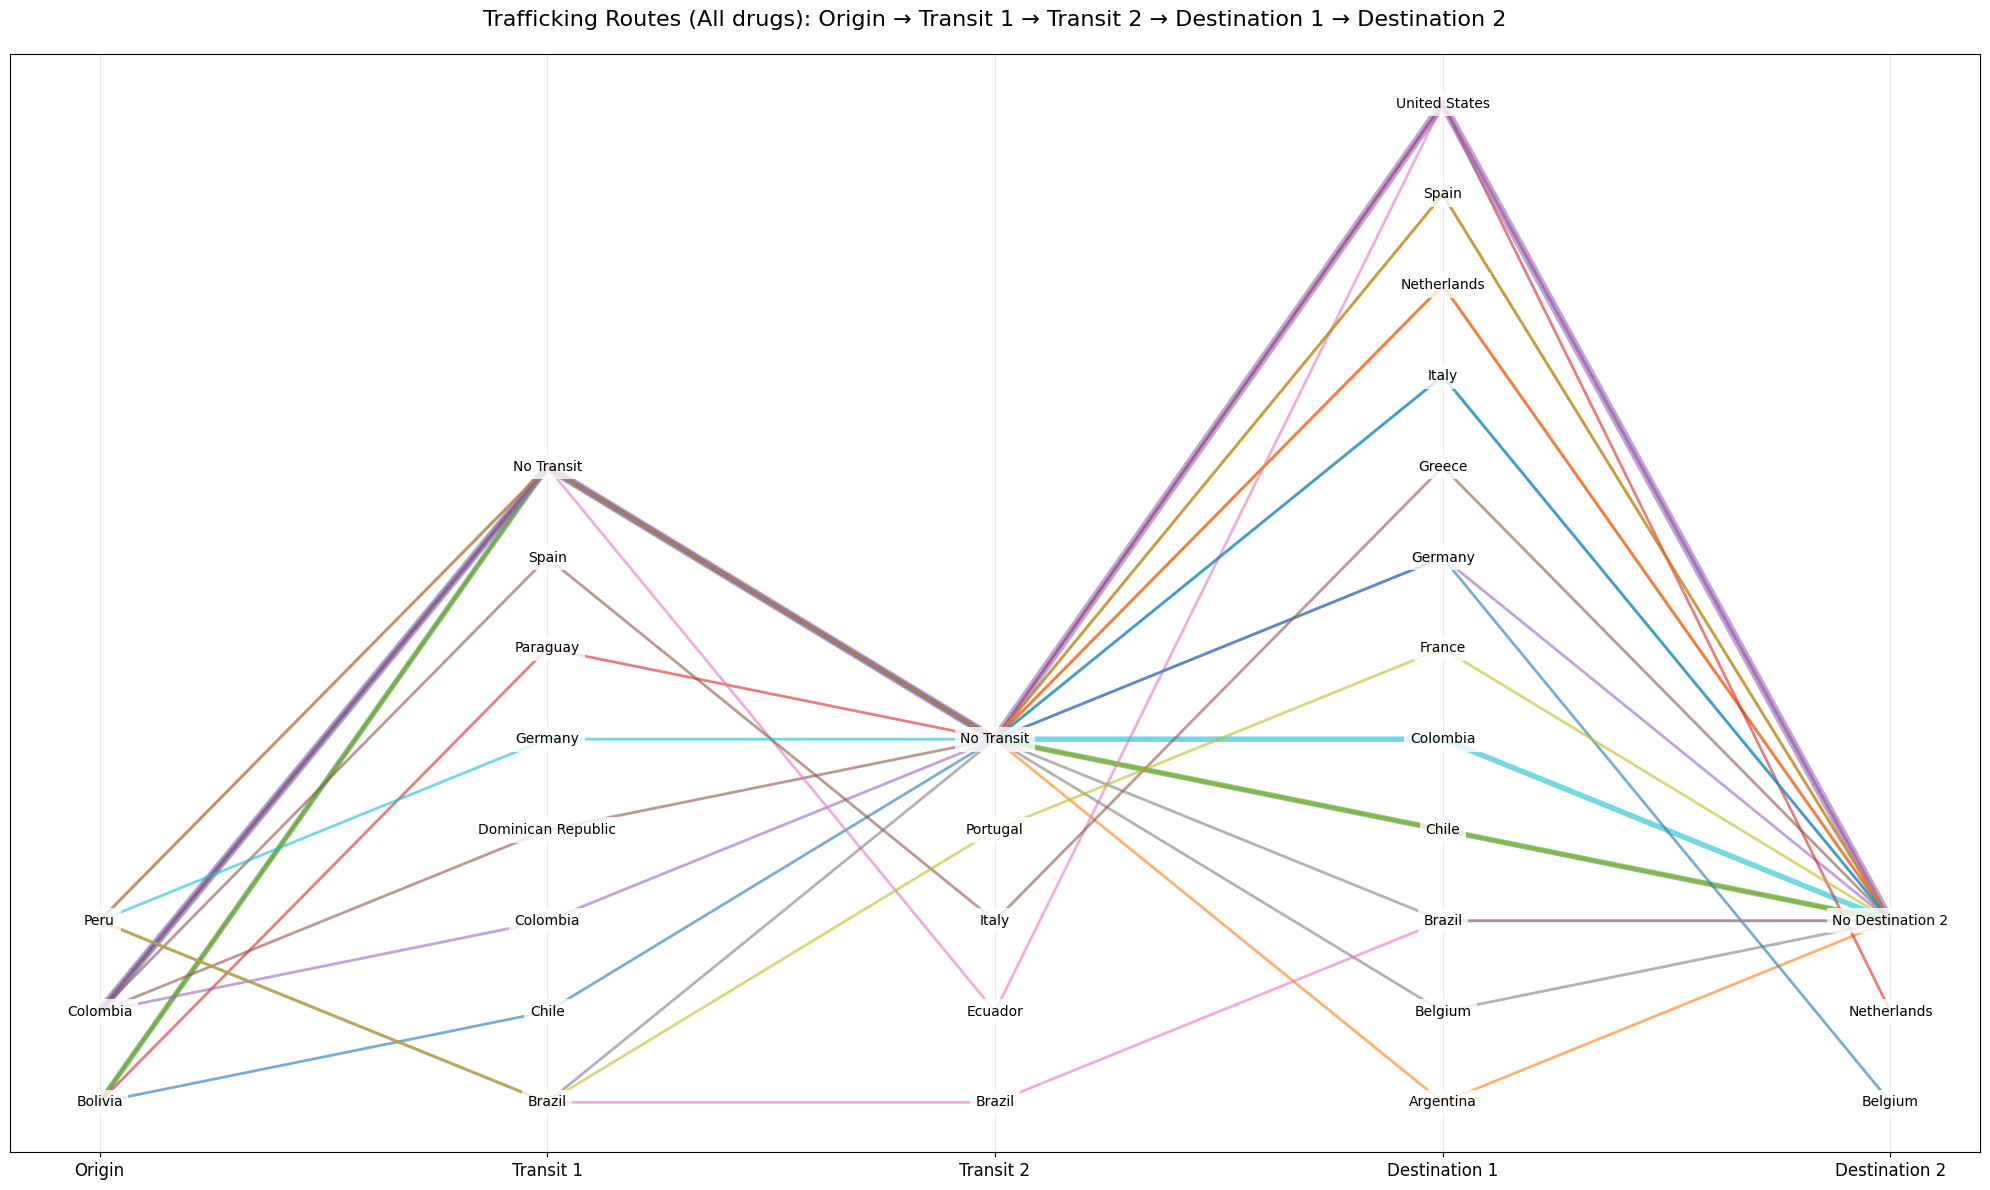

In [15]:
import matplotlib.pyplot as plt

def plot_parallel_sets(df): 
    # Define the column names
    columns = ['Origin country', 'Transit 1/country', 'Transit 2/ country',
               'Destition - Country', 'Destition 2 - Country']
    
    # Copy and fill missing values
    df = df[columns].copy()
    df[columns[1]] = df[columns[1]].fillna('No Transit')
    df[columns[2]] = df[columns[2]].fillna('No Transit')
    df[columns[4]] = df[columns[4]].fillna('No Destination 2')
    
    # Filter incomplete rows
    df.dropna(subset=[columns[0], columns[3]], inplace=True)
    if df.empty:
        print("Warning: No data with both origin and destination information")
        return
    
    # Count path frequencies
    path_counts = df.groupby(columns).size().reset_index(name='count')
    
    # Prepare the plot
    plt.figure(figsize=(20, 12))

    # Map each category to a y-position (starting at 1)
    categories = {}
    for col in columns:
        values = df[col].unique()
        sorted_vals = sorted([v for v in values if "No" not in v]) + sorted([v for v in values if "No" in v])
        categories[col] = {val: idx + 1 for idx, val in enumerate(sorted_vals)}
    
    # Plot each path
    for _, row in path_counts.iterrows():
        y_values = [categories[col][row[col]] for col in columns]
        plt.plot(range(len(columns)), y_values, linewidth=row['count'] * 2, alpha=0.6)

    # X-axis: step names
    plt.xticks(range(len(columns)), ['Origin', 'Transit 1', 'Transit 2', 'Destination 1', 'Destination 2'], fontsize=12)
    
    # Y-axis: remove default numbers
    plt.yticks([])
    
    # Add node labels
    for i, col in enumerate(columns):
        for val, y in categories[col].items():
            plt.text(i, y, val, ha='center', va='center',
                     bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'), fontsize=10)
    
    # Final touches
    plt.title("Trafficking Routes (All drugs): Origin → Transit 1 → Transit 2 → Destination 1 → Destination 2", 
              fontsize=16, pad=20)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_parallel_sets(df)

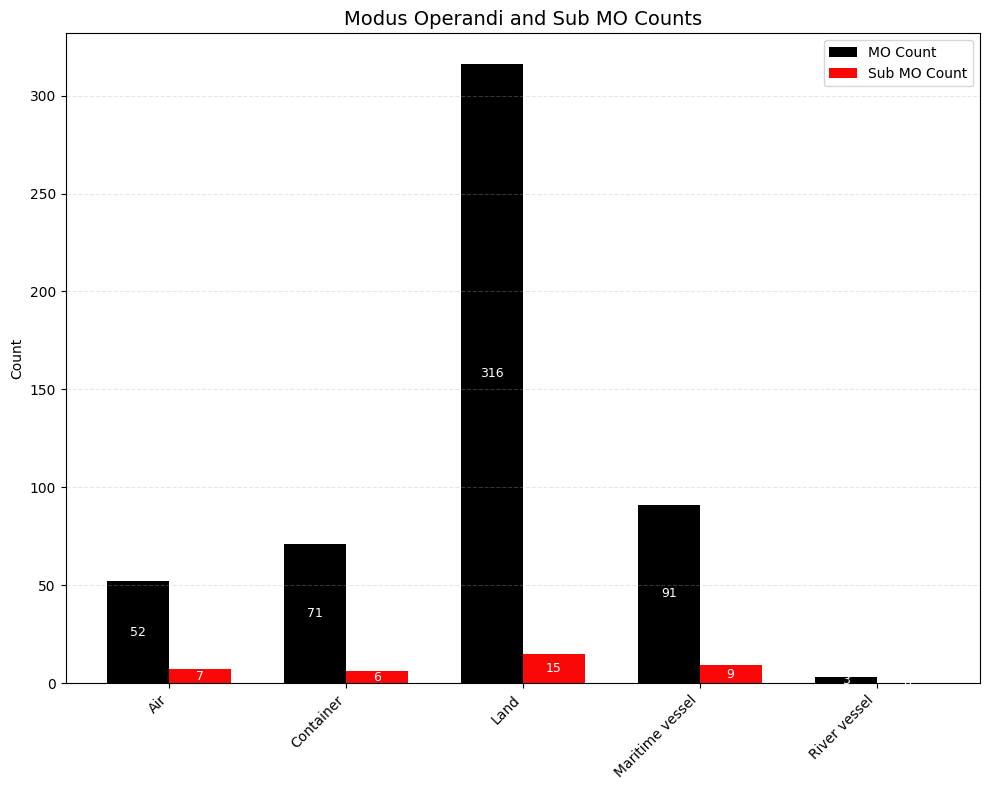

In [17]:
import numpy as np

# Group counts
mo = df['Modus Operandi/place of seizure'].value_counts().sort_index()
sub_mo = df.groupby('Modus Operandi/place of seizure')['Sub MO'].count().reindex(mo.index)

# Plot
labels = mo.index
x = np.arange(len(labels))
w = 0.35

fig, ax = plt.subplots(figsize=(10, 8))
b1 = ax.bar(x - w/2, mo, w, label='MO Count', color="#000000")
b2 = ax.bar(x + w/2, sub_mo, w, label='Sub MO Count', color="#FA0707")

# Label bars
for bars in [b1, b2]:
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2,
                str(int(bar.get_height())), ha='center', va='center', color='white', fontsize=9)

# Style
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_title('Modus Operandi and Sub MO Counts', fontsize=14)
ax.legend()
ax.set_ylabel('Count')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()



## Validation

#### General

##### Column names

In [18]:
# Dictionary mapping old column names to new names
custom_column_names = {
    "Type": "event_type",
    "Time unit": "time_unit",
    "Date": "date_1",
    "Date 2": "date_2",
    "Year": "year",
    "Month": "month",
    "Day": "day",
    "Duration": "duration",
    "Type Drugs": "drug_type",
    "Quantity": "quantity",
    "Weight unit": "weight_unit",
    "seizure_kgs": "seizure_kg",
    "Modus Operandi/place of seizure": "modus_operandi/place_seizure",
    "Sub MO": "sub_modus_operandi",
    "Region": "region",
    "Country": "country",
    "Department/State": "department/state",
    "Municipality/Port": "municipality/port",
    "Origin country": "origin_country",
    "Origin Area": "origin_area",
    "Origin municipality": "origin_municipality",
    "Transit 1/Region": "transit_1_region",
    "Transit 1/country": "transit_1_country",
    "Transit 1/Department": "transit_1_department/state",
    "Transit 1/Municipality": "transit_1_municipality/port",
    "Transit 2/ region": "transit_2_region",
    "Transit 2/ country": "transit_2_country",
    "Transit 2/Department": "transit_2_department/state",
    "Transit 2/municipality/port": "transit_2_municipality/port",
    "Destition - Region": "destination_1_region",
    "Destition - Country": "destination_1_country",
    "Destition - department.state": "destination_1_department/state",
    "Destition - Municipality/Port": "destination_1_municipality/port",
    "Destition 2 - Country": "destination_2_country",
    "Destition 2 - Municipality/Port": "destination_2_municipality/port",
    "Description": "description",
    "Criminal group #1": "criminal_group_1",
    "Criminal group #2": "criminal_group_2",
    "Criminal group #3": "criminal_group_3",
    "Source link": "source_link",
    "Project interested": "project_interest"
}

# Apply renaming
df.rename(columns=custom_column_names, inplace=True)


In [19]:
# Get the current headers to map them
current_headers = sheet.values().get(
    spreadsheetId=TEST_SPREADSHEET_ID,
    range=f"{RANGE_NAME.split('!')[0]}!1:1",  # Get just header row
    majorDimension="ROWS"
).execute().get('values', [[]])[0]

# Create new headers list by mapping old names to new names
new_headers = [custom_column_names.get(header, header) for header in current_headers]

# Update just the header row
sheet.values().update(
    spreadsheetId=TEST_SPREADSHEET_ID,
    range=f"{RANGE_NAME.split('!')[0]}!1:1",  # Update just header row
    valueInputOption='RAW',
    body={'values': [new_headers]}
).execute()

print("Column names updated (while preserving data and formatting)!")

Column names updated (while preserving data and formatting)!


##### Dropdowns

###### Options

In [20]:
# Indentify Existing Dropdowns
 
def get_sheet_dropdowns(spreadsheet_id, sheet_name, creds):
    service = build('sheets', 'v4', credentials=creds)
    sheet_metadata = service.spreadsheets().get(
        spreadsheetId=spreadsheet_id,
        ranges=[sheet_name],
        includeGridData=True
    ).execute()

    dropdowns_by_column = {}

    for sheet in sheet_metadata['sheets']:
        if sheet['properties']['title'] != sheet_name:
            continue

        col_dropdowns = {}
        rows = sheet['data'][0]['rowData']
        header_row = rows[0]['values']
        col_names = [cell.get('formattedValue', f"Column_{i}") for i, cell in enumerate(header_row)]

        for col_idx, col_name in enumerate(col_names):
            dropdowns_in_col = set()
            for row in rows[1:]:  # Skip header
                cell = row['values'][col_idx]
                if 'dataValidation' in cell:
                    dv = cell['dataValidation']
                    if dv['condition']['type'] == 'ONE_OF_LIST':
                        values = [v['userEnteredValue'] for v in dv['condition']['values']]
                        dropdowns_in_col.update(values)
            if dropdowns_in_col:
                col_dropdowns[col_name] = list(dropdowns_in_col)

        dropdowns_by_column.update(col_dropdowns)

    return dropdowns_by_column

dropdown_options = get_sheet_dropdowns(TEST_SPREADSHEET_ID, '2025', creds)

# Print results
for col, options in dropdown_options.items():
    print(f"🔽 {col}: {options}")


🔽 event_type: ['Other (explain in Description)', 'Price', 'Crop Eradication', 'Seizure', 'Total Crop Cultivation Estimate', 'Total Production Estimate']
🔽 time_unit: ['Month', 'Multi-Year', 'Other (explain in Description)', 'Individual', 'Multi-Month', 'Year']
🔽 drug_type: ['Cocaine', 'Other (explain in Description)', 'Coca Crops', 'Cocaine - Crack', 'Cocaine Base', 'All/Unspecified/Multiple']
🔽 weight_unit: ['Percent', 'Pounds (lbs)', 'USD', 'Other currency (say which in Description)', 'Other (explain in Description)', 'Package', 'Hectare', 'Plant', 'Pounds (£)', 'Kilogram', 'Euro']
🔽 modus_operandi/place_seizure: ['Container', 'Air', 'Land', 'Maritime vessel', 'River vessel']
🔽 region: ['Caribbean', 'Oceania', 'Central America', 'Europe', 'Africa', 'South America', 'North America', 'Global', 'Asia']
🔽 origin_country: ['Bolivia', '""', 'Colombia', 'Peru']
🔽 transit_1_region: ['Caribbean', 'Oceania', 'Central America', 'Europe', 'Africa', 'South America', 'North America', 'Global', 'As

In [21]:
dropdown_options = {
    "event_type": [
        'Crop Eradication', 'Total Crop Cultivation Estimate', 'Price',
        'Total Production Estimate', 'Other (explain in Description)', 'Seizure'
    ],
    "time_unit": [
        'Multi-Year', 'Multi-Month', 'Month', 'Other (explain in Description)',
        'Individual', 'Year'
    ],
    "drug_type": [
        'Coca Crops', 'All/Unspecified/Multiple', 'Cocaine',
        'Other (explain in Description)', 'Cocaine - Crack', 'Cocaine Base'
    ],
    "weight_unit": [
        'Percent', 'Other currency (say which in Description)', 'Hectare',
        'Euro', 'Plant', 'USD', 'Other (explain in Description)',
        'Pounds (lbs)', 'Kilogram', 'Pounds (£)', 'Package'
    ],
    "modus_operandi/place_seizure": [
        'River vessel', 'Container', 'Maritime vessel', 'Land', 'Air'
    ],
    "region": [
        'Global', 'Central America', 'Asia', 'Europe', 'Oceania',
        'South America', 'Caribbean', 'North America', 'Africa'
    ],
    "origin_country": ['Peru', 'Bolivia', 'Unknown', 'Colombia'], # '""' REPLACED with 'Unknown'
    
    "transit_1_region": [
        'Global', 'Central America', 'Asia', 'Europe', 'Oceania',
        'South America', 'Caribbean', 'North America', 'Africa'
    ],
    "transit_2_region": [
        'Global', 'Central America', 'Asia', 'Europe', 'Oceania',
        'South America', 'Caribbean', 'North America', 'Africa'
    ],
    "destination_1_region": [
        'Central America', 'Asia', 'Europe', 'South America',
        'Caribbean', 'North America', 'Australia', 'Africa'
    ],
    
    "project_interest": ['Cocaine Pipeline', 'El PACCTO 2.0', 'MAD', 'Dutch']
}

###### Places

In [22]:
# Official list of places URL 
places_url = "https://github.com/FelipeVillota/db-check-cocaine-seizures/raw/main/other/list-of-places-ic.xlsx"

# Load the Excel file (defaulting to first sheet, or specify sheet_name if needed)
places_df = pd.read_excel(places_url)

# Preview the columns to identify the correct one for country list
print(places_df.columns)

print("\nColumns and their unique value counts:")
for col in places_df.columns:
    unique_count = places_df[col].nunique()
    print(f"{col}: {unique_count} unique values")

Index(['municipality', 'department/state', 'country'], dtype='object')

Columns and their unique value counts:
municipality: 129008 unique values
department/state: 3355 unique values
country: 192 unique values


In [23]:
official_countries = (
    places_df["country"]  
    .dropna()
    .astype(str)
    .str.strip()
    .unique()
    .tolist()
)

official_municipalities = (
    places_df["municipality"] 
    .dropna()
    .astype(str)
    .str.strip()
    .unique()
    .tolist()
)

official_departments_states = (
    places_df["department/state"] 
    .dropna()
    .astype(str)
    .str.strip()
    .unique()
    .tolist()
)

In [24]:
country_related_keys = [
    "country",
    "origin_country",
    "transit_1_country",
    "transit_2_country",
    "destination_1_country",
    "destination_2_country"
]

# municipality_related_keys = [
#     "municipality/port",
#     "origin_municipality",
#     "transit_1_municipality/port",
#     "transit_2_municipality/port",
#     "destination_1_municipality/port",
#     "destination_2_municipality/port"
# ]

# department_state_related_keys = [
#     "department/state",
#     # "origin_area",  # assuming this is equivalent
#     "transit_1_department/state",
#     "transit_2_department/state",
#     "destination_1_department/state"
# ]

# Process country-related keys 
for key in country_related_keys:
    dropdown_options[key] = {
        "from_data": sorted(df[key].dropna().astype(str).str.strip().unique().tolist()) if key in df.columns else [],
        "official_list": sorted(official_countries)
    }

# # to municipalities
# for key in municipality_related_keys:
#     dropdown_options[key] = {
#         "from_data": sorted(df[key].dropna().astype(str).str.strip().unique().tolist()) if key in df.columns else [],
#         "official_list": sorted(official_municipalities)
#     }

# # to departments/states
# for key in department_state_related_keys:
#     dropdown_options[key] = {
#         "from_data": sorted(df[key].dropna().astype(str).str.strip().unique().tolist()) if key in df.columns else [],
#         "official_list": sorted(official_departments_states)
#     }


In [25]:
dropdown_options["origin_country"]

{'from_data': ['Bolivia', 'Colombia', 'Peru'],
 'official_list': ['Afghanistan',
  'Albania',
  'Algeria',
  'Andorra',
  'Angola',
  'Antigua And Barbuda',
  'Argentina',
  'Armenia',
  'Australia',
  'Austria',
  'Azerbaijan',
  'Bahamas The',
  'Bahrain',
  'Bangladesh',
  'Barbados',
  'Belarus',
  'Belgium',
  'Belize',
  'Benin',
  'Bhutan',
  'Bolivia',
  'Bosnia and Herzegovina',
  'Botswana',
  'Brazil',
  'Brunei',
  'Bulgaria',
  'Burkina Faso',
  'Burundi',
  'Cambodia',
  'Cameroon',
  'Canada',
  'Cape Verde',
  'Central African Republic',
  'Chad',
  'Chile',
  'China',
  'Colombia',
  'Comoros',
  'Congo',
  'Congo The Democratic Republic Of The',
  'Costa Rica',
  "Cote D'Ivoire (Ivory Coast)",
  'Croatia (Hrvatska)',
  'Cuba',
  'Cyprus',
  'Czech Republic',
  'Denmark',
  'Djibouti',
  'Dominica',
  'Dominican Republic',
  'East Timor',
  'Ecuador',
  'Egypt',
  'El Salvador',
  'Equatorial Guinea',
  'Eritrea',
  'Estonia',
  'Ethiopia',
  'Fiji Islands',
  'Finland

In [26]:
def apply_dropdowns_to_sheet(sheet_service, spreadsheet_id, sheet_name, dropdown_options, max_rows=150000):
    # Get the actual sheetId from the sheet name
    spreadsheet = sheet_service.spreadsheets().get(spreadsheetId=spreadsheet_id).execute()
    sheet_id = None
    for sheet in spreadsheet['sheets']:
        if sheet['properties']['title'] == sheet_name:
            sheet_id = sheet['properties']['sheetId']
            break
    if sheet_id is None:
        print(f"❌ Sheet name '{sheet_name}' not found.")
        return

    # Get header row (assumed to be row 1)
    result = sheet_service.spreadsheets().values().get(
        spreadsheetId=spreadsheet_id,
        range=f"{sheet_name}!1:1"
    ).execute()
    headers = result.get('values', [])[0]

    requests = []

    for col_name, options in dropdown_options.items():
        if col_name not in headers:
            continue

        col_index = headers.index(col_name)
        values = (
            options.get("official_list", []) if isinstance(options, dict)
            else options
        )
        values = values[:500]  # Apparently it can only handle this, or else it breaks the API

        if not values:
            continue

        validation_rule = {
            "condition": {
                "type": "ONE_OF_LIST",
                "values": [{"userEnteredValue": str(v)} for v in values]
            },
            "strict": True,
            "showCustomUi": True
        }

        requests.append({
            "setDataValidation": {
                "range": {
                    "sheetId": sheet_id,
                    "startRowIndex": 1,
                    "endRowIndex": max_rows,
                    "startColumnIndex": col_index,
                    "endColumnIndex": col_index + 1
                },
                "rule": validation_rule
            }
        })

    if requests:
        try:
            sheet_service.spreadsheets().batchUpdate(
                spreadsheetId=spreadsheet_id,
                body={"requests": requests}
            ).execute()
            print(f"✅ Applied dropdowns to {len(requests)} columns.")
        except Exception as e:
            print(f"❌ Error applying dropdowns: {e}")
    else:
        print("⚠️ No matching columns found in the sheet.")
        
apply_dropdowns_to_sheet(
    sheet_service=sheet_service,
    spreadsheet_id=TEST_SPREADSHEET_ID,  
    sheet_name="2025",                 
    dropdown_options=dropdown_options, 
    max_rows=150000                  
)


✅ Applied dropdowns to 16 columns.


#### Event Metadata

Variables: _Type, Time unit, Date, Date 2, Year, Month, Day, Duration, Description, Source link, Project interested_

In [27]:
def event_metadata_report(df):
    report = []
    issues = {}
    total_problems = 0  # Initialize counter for total problems
    
    # Convert pandas indices to spreadsheet rows (+2 for header + zero-index)
    def to_excel_rows(indices):
        return [i+2 for i in indices]  # For spreadsheet row reference

    # Validation 1: Empty Dates
    if 'date' not in df.columns:
        report.append(("❌ Missing Column", "'date' column not found"))
        total_problems += 1  # Count missing column as a problem
    else:
        empty_dates = df[df['date'].isna()]
        if not empty_dates.empty:
            issue_rows = empty_dates.index.tolist()
            excel_rows = to_excel_rows(issue_rows)
            issues['empty_dates'] = {
                'indices': issue_rows,
                'excel_rows': excel_rows,
                'sample': empty_dates
            }
            report.append(("❌ Empty Dates", 
                         f"{len(empty_dates)} rows at spreadsheet rows: {excel_rows}"))
            total_problems += len(empty_dates)

    # Validation 2: Duration without Date 2
    missing_cols = [col for col in ['date', 'date_2', 'duration'] if col not in df.columns]
    if missing_cols:
        report.append(("❌ Missing Columns", f"Columns not found: {', '.join(missing_cols)}"))
        total_problems += len(missing_cols)  # Count each missing column
    else:
        invalid_duration = df[(df['date_2'].isna()) & (df['duration'].notna())]
        if not invalid_duration.empty:
            issue_rows = invalid_duration.index.tolist()
            excel_rows = to_excel_rows(issue_rows)
            issues['invalid_duration'] = {
                'indices': issue_rows,
                'excel_rows': excel_rows,
                'sample': invalid_duration
            }
            report.append(("❌ Duration Conflict", 
                         f"{len(invalid_duration)} rows at spreadsheet rows: {excel_rows}"))
            total_problems += len(invalid_duration)

    # Validation 3: Time unit inconsistency
    if 'time_unit' not in df.columns:
        report.append(("❌ Missing Column", "'time_unit' column not found"))
        total_problems += 1  # Count missing column
    else:
        invalid_time = df[(df['date_2'].notna()) & (df['time_unit'] == 'Individual')]
        if not invalid_time.empty:
            issue_rows = invalid_time.index.tolist()
            excel_rows = to_excel_rows(issue_rows)
            issues['invalid_time'] = {
                'indices': issue_rows,
                'excel_rows': excel_rows,
                'sample': invalid_time
            }
            report.append(("❌ Time Unit Conflict", 
                         f"{len(invalid_time)} rows at spreadsheet rows: {excel_rows}"))
            total_problems += len(invalid_time) 

    # Print formatted report
    print("="*80)
    print(f"EVENT METADATA REPORT (Problematic Rows in Total: {total_problems})".center(80))
    print("="*80)
    
    # Summary section
    print("\nSUMMARY:")
    for check, message in report:
        print(f"{check:<30} {message}")
    
    # Problematic rows
    print("\n"+ "="*80)
    print("PROBLEMATIC ROWS".center(80))
    print("="*80)
    
    for issue_name, data in issues.items():
        if len(data['indices']) > 0:
            print(f"\n🔴 {issue_name.replace('_', ' ').upper()} ({len(data['indices'])} ROWS)")
            print(f"Spreadsheet Rows: {data['excel_rows']}")
            print("\nProblematic Data:")
            print(data['sample'].to_string(index=False))
            print("-"*40)
    
    print("\n" + "="*80)
    print("ℹ️ Spreadsheet rows account for header row (pandas index + 2)")
    print("="*80)
    
    return issues

# Usage
validation_results = event_metadata_report(df)

              EVENT METADATA REPORT (Problematic Rows in Total: 5)              

SUMMARY:
❌ Empty Dates                  2 rows at spreadsheet rows: [219, 282]
❌ Duration Conflict            1 rows at spreadsheet rows: [341]
❌ Time Unit Conflict           2 rows at spreadsheet rows: [44, 48]

                                PROBLEMATIC ROWS                                

🔴 EMPTY DATES (2 ROWS)
Spreadsheet Rows: [219, 282]

Problematic Data:
event_type  time_unit date_1 date_2 year month  day duration drug_type quantity weight_unit  seizure_kg modus_operandi/place_seizure sub_modus_operandi        region  country department/state municipality/port origin_country origin_area origin_municipality transit_1_region transit_1_country transit_1_department/state transit_1_municipality/port transit_2_region transit_2_country transit_2_department/state transit_2_municipality/port destination_1_region destination_1_country destination_1_department/state destination_1_municipality/port destinati

In [28]:
def apply_conditional_formatting(sheet_service, spreadsheet_id, sheet_name, rows_to_highlight):
    """Apply RED background formatting to specified rows."""
    if not rows_to_highlight:
        print("No rows to highlight")
        return
    
    # Build conditional formatting rules (batch all rows in one request for efficiency)
    requests = {
        "requests": [
            {
                "addConditionalFormatRule": {
                    "rule": {
                        "ranges": [
                            {
                                "sheetId": sheet_name,  # This should be the sheet ID, not name
                                "startRowIndex": row - 1,  # Convert to 0-based index
                                "endRowIndex": row,       # End is exclusive
                                "startColumnIndex": 0,
                                "endColumnIndex": 26      # Assuming 26 columns (A-Z)
                            } for row in rows_to_highlight
                        ],
                        "booleanRule": {
                            "format": {
                                "backgroundColor": {
                                    "red": 1.0,
                                    "green": 0.0,
                                    "blue": 0.0
                                }
                            },
                            "condition": {
                                "type": "CUSTOM_FORMULA",
                                "values": [
                                    {
                                        "userEnteredValue": "=TRUE"
                                    }
                                ]
                            }
                        }
                    },
                    "index": 0
                }
            }
        ]
    }
    
    try:
        # First we need to get the sheet ID from the sheet name
        spreadsheet = sheet_service.spreadsheets().get(
            spreadsheetId=spreadsheet_id,
            fields="sheets(properties(sheetId,title))"
        ).execute()
        
        sheet_id = None
        for sheet in spreadsheet['sheets']:
            if sheet['properties']['title'] == sheet_name:
                sheet_id = sheet['properties']['sheetId']
                break
        
        if not sheet_id:
            print(f"Sheet '{sheet_name}' not found")
            return
        
        # Update the requests with the correct sheet IDs
        for request in requests['requests']:
            for range_ in request['addConditionalFormatRule']['rule']['ranges']:
                range_['sheetId'] = sheet_id
        
        # Execute the request
        response = sheet_service.spreadsheets().batchUpdate(
            spreadsheetId=spreadsheet_id,
            body=requests
        ).execute()
        
        print(f"Successfully highlighted {len(rows_to_highlight)} rows in red")
        
    except Exception as e:
        print(f"Error applying conditional formatting: {str(e)}")

# Get all problematic rows from validation results
all_problem_rows = []
for issue in validation_results.values():
    all_problem_rows.extend(issue['excel_rows'])

# Remove duplicates and sort
all_problem_rows = sorted(list(set(all_problem_rows)))

# Apply the formatting
apply_conditional_formatting(
    sheet_service=sheet_service,
    spreadsheet_id=TEST_SPREADSHEET_ID,
    sheet_name=RANGE_NAME,  # '2025' in your case
    rows_to_highlight=all_problem_rows
)

Successfully highlighted 5 rows in red


#### Drugs & Quantities

Variables: _Type Drugs, Quantity, Weight unit, seizure_kgs_

In [29]:
def drugs_and_quantities_report(df):
    report = []
    issues = {}
    total_problems = 0

    def to_excel_rows(indices):
        return [i + 2 for i in indices]  # For spreadsheet row reference

    # Validation 1: Missing or Unknown Types of Drugs
    if 'drug_type' not in df.columns:
        report.append(("❌ Missing Column", "'drug_type' column not found"))
        total_problems += 1  # Count missing column as a problem
    else:
        invalid_drugs = df[df['drug_type'].isna() | df['drug_type'].str.lower().isin(['', 'unknown', 'n/a', 'na'])]
        if not invalid_drugs.empty:
            issue_rows = invalid_drugs.index.tolist()
            excel_rows = to_excel_rows(issue_rows)
            issues['invalid_drug_type'] = {
                'indices': issue_rows,
                'excel_rows': excel_rows,
                'sample': invalid_drugs
            }
            report.append(("❌ Invalid Drug Types", 
                         f"{len(invalid_drugs)} rows at spreadsheet rows: {excel_rows}"))
            total_problems += len(invalid_drugs)

    # Validation 2: Missing, Not numeric quantities or ≤ 0 
    if 'quantity' not in df.columns:
        report.append(("❌ Missing Column", "'quantity' column not found"))
        total_problems += 1
    else:
        numeric_qty = pd.to_numeric(df['quantity'], errors='coerce')
        non_numeric_qty = df[numeric_qty.isna()]
        zero_or_negative_qty = df[(numeric_qty.notna()) & (numeric_qty <= 0)]
        qty_issues = pd.concat([non_numeric_qty, zero_or_negative_qty]).drop_duplicates()
        if not qty_issues.empty:
            issue_rows = qty_issues.index.tolist()
            excel_rows = to_excel_rows(issue_rows)
            issues['invalid_quantity'] = {
                'indices': issue_rows,
                'excel_rows': excel_rows,
                'sample': qty_issues
            }
            report.append(("❌ Invalid Quantities", 
                         f"{len(qty_issues)} rows at spreadsheet rows: {excel_rows}"))
            total_problems += len(qty_issues)

    # Validation 3: Missing, Invalid or Unrecognized Weight Units
    if 'weight_unit' not in df.columns:
        report.append(("❌ Missing Column", "'weight_unit' column not found"))
        total_problems += 1
    else:
        valid_units = dropdown_options.get('weight_unit', [])
        valid_units_lower = [str(unit).lower() for unit in valid_units]
        
        invalid_units = df[
            ~df['weight_unit'].astype(str).str.lower().isin(valid_units_lower)
            | df['weight_unit'].isna()
        ]
        
        if not invalid_units.empty:
            issue_rows = invalid_units.index.tolist()
            excel_rows = to_excel_rows(issue_rows)
            issues['invalid_weight_unit'] = {
                'indices': issue_rows,
                'excel_rows': excel_rows,
                'sample': invalid_units,
                'valid_options': valid_units
            }
            report.append((
                "❌ Invalid Weight Units", 
                f"{len(invalid_units)} rows with invalid/missing units at spreadsheet rows: {excel_rows}. "
                f"Valid options are: {', '.join(valid_units)}"
            ))
            total_problems += len(invalid_units)

    # Validation 4: Missing, Not numeric or Negative Seizure in Kilograms
    if 'seizure_kg' not in df.columns:
        report.append(("❌ Missing Column", "'seizure_kg' column not found"))
        total_problems += 1
    else:
        numeric_seizure = pd.to_numeric(df['seizure_kg'], errors='coerce')
        invalid_seizure = df[
            numeric_seizure.isna() |
            (numeric_seizure < 0)
        ]
        if not invalid_seizure.empty:
            issue_rows = invalid_seizure.index.tolist()
            excel_rows = to_excel_rows(issue_rows)
            issues['invalid_seizure_kg'] = {
                'indices': issue_rows,
                'excel_rows': excel_rows,
                'sample': invalid_seizure
            }
            report.append(("❌ Invalid Seizure Weights", 
                         f"{len(invalid_seizure)} rows at spreadsheet rows: {excel_rows}"))
            total_problems += len(invalid_seizure)

    # FORMATTED REPORT OUTPUT
    print("="*80)
    print(f"DRUGS & QUANTITIES REPORT (Problematic Rows in Total: {total_problems})".center(80))
    print("="*80)

    print("\nSUMMARY:")
    for check, message in report:
        print(f"{check:<30} {message}")

    print("\n"+ "="*80)
    print("PROBLEMATIC ROWS".center(80))
    print("="*80)

    for issue_name, data in issues.items():
        if len(data['indices']) > 0:
            print(f"\n🔴 {issue_name.replace('_', ' ').upper()} ({len(data['indices'])} ROWS)")
            print(f"Spreadsheet Rows: {data['excel_rows']}")
            print("\nProblematic Data:")
            print(data['sample'].to_string(index=False))
            print("-"*40)

    print("\n" + "="*80)
    print("ℹ️ Spreadsheet rows account for header row (pandas index + 2)")
    print("="*80)

    return issues

drugs_and_quantities_report(df)

           DRUGS & QUANTITIES REPORT (Problematic Rows in Total: 137)           

SUMMARY:
❌ Invalid Quantities           10 rows at spreadsheet rows: [100, 187, 195, 214, 226, 237, 333, 350, 386, 396]
❌ Invalid Weight Units         2 rows with invalid/missing units at spreadsheet rows: [100, 350]. Valid options are: Percent, Other currency (say which in Description), Hectare, Euro, Plant, USD, Other (explain in Description), Pounds (lbs), Kilogram, Pounds (£), Package
❌ Invalid Seizure Weights      125 rows at spreadsheet rows: [100, 181, 183, 185, 187, 193, 194, 197, 198, 199, 200, 201, 202, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 238, 239, 240, 317, 319, 330, 333, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381,

{'invalid_quantity': {'indices': [98,
   185,
   193,
   212,
   224,
   235,
   331,
   348,
   384,
   394],
  'excel_rows': [100, 187, 195, 214, 226, 237, 333, 350, 386, 396],
  'sample':     event_type                       time_unit      date_1 date_2  year month  \
  98     Seizure                      Individual  2025-04-14   <NA>  2025     4   
  185    Seizure                      Individual  2025-04-05   <NA>  2025     4   
  193    Seizure                      Individual  2025-05-06   <NA>  2025     5   
  212    Seizure  Other (explain in Description)  2025-04-30   <NA>  2025     4   
  224    Seizure                      Individual  2025-05-13   <NA>  2025     5   
  235    Seizure                      Individual  2025-03-20   <NA>  2025     3   
  331    Seizure                      Individual  2025-05-31   <NA>  2025     5   
  348    Seizure                      Individual  2025-06-06   <NA>  2025     6   
  384    Seizure                      Individual  2025-06-06   <

In [31]:
def apply_conditional_formatting(sheet_service, spreadsheet_id, sheet_name, validation_results):
    """" Apply LIGHT BLUE background formatting to specified rows."""
    if not validation_results:
        print("No validation issues found - nothing to highlight")
        return
    
    # Collect all unique problematic rows from all validation issues
    all_problem_rows = []
    for issue in validation_results.values():
        all_problem_rows.extend(issue['excel_rows'])
    
    # Remove duplicates and sort
    all_problem_rows = sorted(list(set(all_problem_rows)))
    
    if not all_problem_rows:
        print("No rows to highlight")
        return
    
    try:
        # First get the sheet ID from the sheet name
        spreadsheet = sheet_service.spreadsheets().get(
            spreadsheetId=spreadsheet_id,
            fields="sheets(properties(sheetId,title))"
        ).execute()
        
        sheet_id = None
        for sheet in spreadsheet['sheets']:
            if sheet['properties']['title'] == sheet_name:
                sheet_id = sheet['properties']['sheetId']
                break
        
        if not sheet_id:
            print(f"Sheet '{sheet_name}' not found")
            return
        
        # Build conditional formatting rules (batch all rows in one request for efficiency)
        requests = {
            "requests": [
                {
                    "addConditionalFormatRule": {
                        "rule": {
                            "ranges": [
                                {
                                    "sheetId": sheet_id,
                                    "startRowIndex": row - 1,  # Convert to 0-based index
                                    "endRowIndex": row,         # End is exclusive
                                    "startColumnIndex": 0,
                                    "endColumnIndex": 26        
                                } for row in all_problem_rows
                            ],
                            "booleanRule": {
                                "format": {
                                    "backgroundColor": {
                                        "red": 0.6,
                                        "green": 0.8, 
                                        "blue": 1.0
                                    },
                                    "textFormat": {
                                        "bold": True
                                    }
                                },
                                "condition": {
                                    "type": "CUSTOM_FORMULA",
                                    "values": [
                                        {
                                            "userEnteredValue": "=TRUE"
                                        }
                                    ]
                                }
                            }
                        },
                        "index": 0
                    }
                }
            ]
        }
        
        # Execute the request
        response = sheet_service.spreadsheets().batchUpdate(
            spreadsheetId=spreadsheet_id,
            body=requests
        ).execute()
        
        print(f"Successfully highlighted {len(all_problem_rows)} problematic rows in LIGHT BLUE")
        
    except Exception as e:
        print(f"Error applying conditional formatting: {str(e)}")


validation_results = drugs_and_quantities_report(df)

# Apply the formatting
apply_conditional_formatting(
    sheet_service=sheet_service,
    spreadsheet_id=TEST_SPREADSHEET_ID,
    sheet_name=RANGE_NAME,
    validation_results=validation_results
)

           DRUGS & QUANTITIES REPORT (Problematic Rows in Total: 137)           

SUMMARY:
❌ Invalid Quantities           10 rows at spreadsheet rows: [100, 187, 195, 214, 226, 237, 333, 350, 386, 396]
❌ Invalid Weight Units         2 rows with invalid/missing units at spreadsheet rows: [100, 350]. Valid options are: Percent, Other currency (say which in Description), Hectare, Euro, Plant, USD, Other (explain in Description), Pounds (lbs), Kilogram, Pounds (£), Package
❌ Invalid Seizure Weights      125 rows at spreadsheet rows: [100, 181, 183, 185, 187, 193, 194, 197, 198, 199, 200, 201, 202, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 238, 239, 240, 317, 319, 330, 333, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381,

## Progress batch 1
 
✔ Last modified by and at (obvious in the sheet, just automated here for reports)

✔ Standard column names

✔ Dropdowns: Corrections & "Official" list of places added to due cols (country-level)

✔ Event Metadata validation complete: rules and report 

✔ Highlights: after validation report it colors problematic rows in red 


## b.2

✔ Workflow

✔ Drugs & Quantities basic validation complete: rules and report

✔ Highlights: after validation report it colors problematic rows in blue 

✔ Reports now all include total number of problems per thematic area

## b.3

✔ Drugs & Quantities pt 2: last rule & conversion system

✔ Convergent issues: for now can use dif colors, but it will be simpler to have 1 color and work with the reports 

## Pending

? Apply formatting (col names, dropdowns, some data types) 

? Issue formats

